In [1]:
%matplotlib ipympl

In [2]:
from collections import defaultdict
import os.path as op
from cycler import cycler
from glob import glob

import h5py
import numpy as np
import scipy
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from viz import (plot_learning, plot_state_traj, plot_all_units,
                 plot_weight_distr)
from train import solve_ls_batch
from utils import get_gaussian_targets, est_dimensionality

In [3]:
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)

In [4]:
f_names = glob('/home/ryan/Dropbox/data/time_coding_output/2025_09_20/*.hdf5')
f_names = sorted(f_names)
n_nets = len(f_names)

# get simulation parameters/conditions from first data file
with h5py.File(f_names[0], 'r') as f_read:
    # tau, include_stp, noise_tau, noise_std, include_corr_noise, p_rel_range
    sim_params = f_read.get('sim_params')[:]
    n_trials = f_read.get('h_sp').shape[1]
    n_outputs, n_hidden = f_read.get('W_hz').shape

print(sim_params)
n_conditions = len(sim_params)
include_stp = sim_params[:, 1] == 1
net_condition = ['no noise', 'no_noise',
                 'uncorr. noise', 'uncorr. noise',
                 'corr. noise', 'corr. noise',
                 'low hetero.', 'homo.']
sim_type_labels = ['no STP, no noise',
                   'STP, no noise',
                   'no STP + uncorr. noise',
                   'STP + uncorr. noise',
                   'no STP + corr. noise',
                   'STP + corr. noise',
                   'STP + uncorr. noise, low hetero p_rel',
                   'STP + uncorr. noise, homo p_rel']

[[1.e-02 0.e+00 1.e-02 0.e+00 0.e+00 2.e+00]
 [1.e-02 1.e+00 1.e-02 0.e+00 0.e+00 2.e+00]
 [1.e-02 0.e+00 1.e-02 1.e-07 0.e+00 2.e+00]
 [1.e-02 1.e+00 1.e-02 1.e-07 0.e+00 2.e+00]
 [1.e-02 0.e+00 1.e-02 1.e-07 1.e+00 2.e+00]
 [1.e-02 1.e+00 1.e-02 1.e-07 1.e+00 2.e+00]
 [1.e-02 1.e+00 1.e-02 1.e-07 0.e+00 1.e+00]
 [1.e-02 1.e+00 1.e-02 1.e-07 0.e+00 0.e+00]]


In [5]:
# temporal parameters (see param_sweep.py)
dt = 1e-3  # 1 ms
tstop = 1.2  # 1 sec
times = np.arange(-0.1 + dt, tstop + dt, dt)
n_times = len(times)
perturb_dur = 0.05  # 50 ms
perturb_win_mask = np.logical_and(times > -perturb_dur, times < 0)

# target parameters (see param_sweep.py)
targ_std = 0.05 / np.sqrt(2)  # ~35 ms
# tile center of target delays spanning sim duration (minus margins)
delay_times = np.linspace(0.1, 1.0, n_outputs)
n_trials_train = n_trials - 1  # for leave-one-out training/testing
targets_train = get_gaussian_targets(n_trials_train, delay_times, times, targ_std)
targets_test = get_gaussian_targets(1, delay_times, times, targ_std)

# define loss functions
def loss_fn(output, target):
    mse_fn = torch.nn.MSELoss()
    return mse_fn(output, target) / (target ** 2).mean()

In [6]:
# read in data and calculate metrics for each net instance and condition
final_loss = np.zeros((n_nets, n_conditions))
init_loss = np.zeros((n_nets, n_conditions))
dimensionality = np.zeros((n_nets, n_conditions))

for net_idx, f_name in enumerate(f_names):
    print(f'starting analysis for net {net_idx}')
    # read in data
    with h5py.File(f_name, 'r') as f_read:
        w_hz_init = f_read.get('W_hz')[:]
        offset_hz_init = f_read.get('offset_hz')[:]
        hidden_rates = f_read.get('h_sp')[:]
        sim_params = f_read.get('sim_params')[:]

    for cond_idx in range(n_conditions):
        # ...for storing results from each fold of leave-one-out training/testing
        final_losses = list()
        init_losses = list()
        dimensionalities = list()

        # leave-one-out training/testing
        trial_idxs = np.arange(n_trials)
        for trial_idx in trial_idxs:
            # parse trials into two batches, one for testing, the rest for training
            train_mask = trial_idxs != trial_idx
            hidden_rates_train = torch.tensor(hidden_rates[cond_idx, train_mask, :, :])
            hidden_rates_test = torch.tensor(hidden_rates[cond_idx, trial_idx:trial_idx + 1, :, :])

            # solve for output weights and offsets via least squares regression
            w_hz_, offset_hz_ = solve_ls_batch(hidden_rates_train[:, ~perturb_win_mask, :],
                                            targets_train[:, ~perturb_win_mask, :])

            # compute output and loss with **fitted** parameters
            output_batch_test = hidden_rates_test @ w_hz_.T + offset_hz_
            loss = loss_fn(output_batch_test[:, times > 0, :], targets_test[:, times > 0, :])
            final_losses.append(loss)

            # compute output and loss with **initial** parameters
            output_batch_test = hidden_rates_test @ w_hz_init.T + offset_hz_init
            loss = loss_fn(output_batch_test[:, times > 0, :], targets_test[:, times > 0, :])
            init_losses.append(loss)

            # compute dimensionality
            dim = est_dimensionality(hidden_rates[cond_idx, trial_idx, :, :])
            dimensionalities.append(dim)

        final_loss[net_idx, cond_idx] = np.mean(final_losses)
        init_loss[net_idx, cond_idx] = np.mean(init_losses)
        dimensionality[net_idx, cond_idx] = np.mean(dimensionalities)

In [26]:
ylim = [9.23689025700686e-06, 16]

In [25]:
ylim

(9.23689025700686e-06, 0.6774047469200725)

/tmp/ipykernel_76598/2758992771.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')


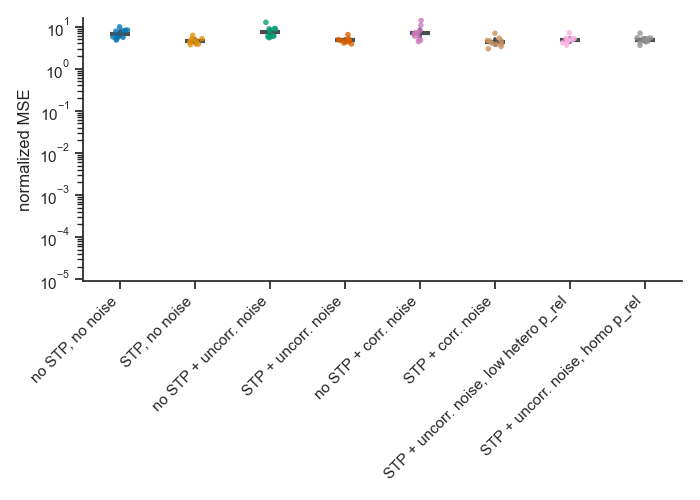

In [27]:
data = {key: init_loss[:, idx] for idx, key in enumerate(sim_type_labels)}
df = pd.DataFrame(data)

fig_init_loss, axes = plt.subplots(figsize=(7, 5))
axes.set_yscale("log")
# sns.violinplot(df, palette='colorblind')
# sns.stripplot(df, size=4, color=".3")
sns.stripplot(df, size=4, palette='colorblind', alpha=0.8)
sns.pointplot(df, marker='_', markersize=15, markeredgewidth=3, color='0.3', linestyle='none')
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
axes.set_ylabel('normalized MSE')
# ylim = axes.get_ylim()
axes.set_ylim(ylim)
fig_init_loss.tight_layout()

fname = 'init_loss.png'
fig_init_loss.savefig(op.join('/home/ryan/Desktop', fname))

/tmp/ipykernel_76598/1812866411.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')


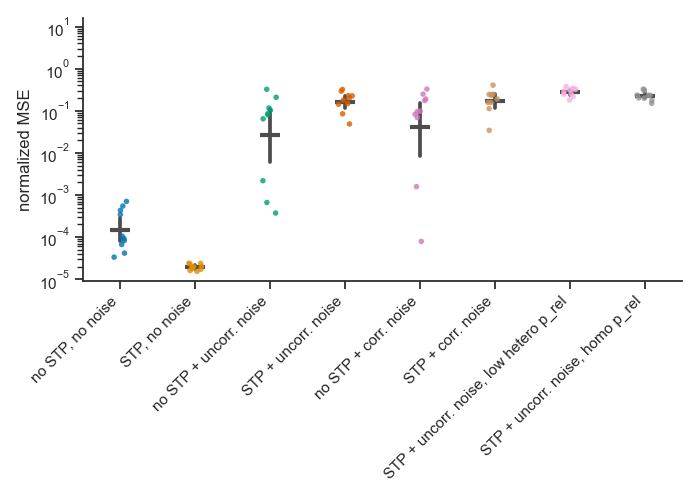

In [28]:
data = {key: final_loss[:, idx] for idx, key in enumerate(sim_type_labels)}
df = pd.DataFrame(data)

fig_final_loss, axes = plt.subplots(figsize=(7, 5))
axes.set_yscale("log")
# sns.violinplot(df, palette='colorblind')
# sns.stripplot(df, size=4, color=".3")
sns.stripplot(df, size=4, palette='colorblind', alpha=0.8)
sns.pointplot(df, marker='_', markersize=15, markeredgewidth=3, color='0.3', linestyle='none')
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
axes.set_ylabel('normalized MSE')
# ylim = axes.get_ylim()
axes.set_ylim(ylim)
fig_final_loss.tight_layout()

fname = 'final_loss.png'
fig_final_loss.savefig(op.join('/home/ryan/Desktop', fname))

/tmp/ipykernel_76598/2682577873.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')


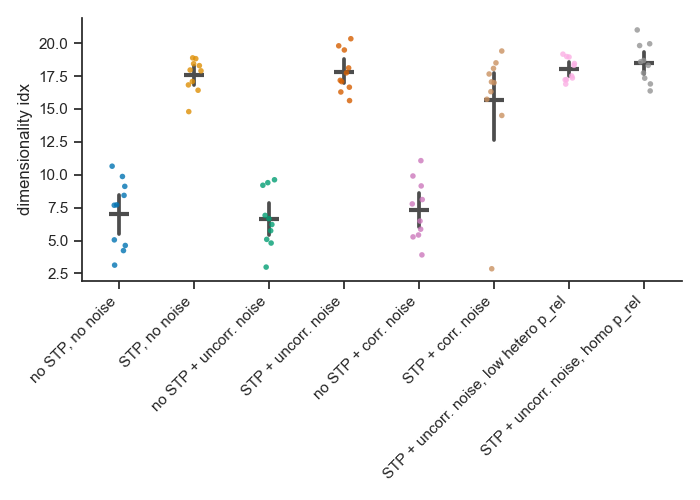

In [16]:
data_dim = {key: dimensionality[:, idx] for idx, key in enumerate(sim_type_labels)}
df_dim = pd.DataFrame(data_dim)

fig_dimensionality, axes = plt.subplots(figsize=(7, 5))
# sns.boxplot(df_dim, fliersize=0, palette='colorblind')
# sns.stripplot(df_dim, size=4, color=".3")

sns.stripplot(df_dim, size=4, palette='colorblind', alpha=0.8)
sns.pointplot(df_dim, marker='_', markersize=15, markeredgewidth=3, color='0.3', linestyle='none')
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
axes.set_ylabel('dimensionality idx')
fig_dimensionality.tight_layout()

fname = 'dimensionality.png'
fig_dimensionality.savefig(op.join('/home/ryan/Desktop', fname))

In [ ]:
# parse data
learning_metrics = defaultdict(list)
learning_metrics['stp'] = param_keys.tolist()
divergences = list()
response_times = list()
perturbation_mags = list()
stp_types = np.repeat(param_keys, 3)

for key in res[0].keys():
    for trial in res:
        if trial[key] is not None:
            if key == 'divergence':
                divergences.extend(trial[key])
            elif key == 'perturbation_mag':
                perturbation_mags.extend(trial[key])
            elif key == 'response_times':
                response_times.extend(np.tile(trial[key], (3, 1)).tolist())
            else:
                learning_metrics[key].append(trial[key])

# fig_divergence, ax = plt.subplots(1, 1, figsize=(3, 3))
# divergence = np.mean(metrics['divergence'], axis=0)
# delay_times = metrics['response_times'][0]
# perturb_mags = metrics['perturbation_mag'][0]
# plot_divergence(divergence, delay_times, perturb_mags, ax=ax)
# fig_divergence.tight_layout()

# plot avg divergence over time for each STP condition w/ error bars
n_times = len(response_times[0])
data = np.array([np.ravel(divergences), np.ravel(response_times),
                 np.repeat(perturbation_mags, n_times),
                 np.repeat(stp_types, n_times)])
div_df = pd.DataFrame(data.T, columns=['MSE', 'time (s)', 'perturbation',
                                       'stp_type'])
fig_divergence, axes = plt.subplots(1, len(param_labels), sharey=True,
                                    figsize=(10, 3))
for stp_type_idx, stp_type in enumerate(param_labels):
    sns.lineplot(data=div_df[div_df['stp_type'] == stp_type], x='time (s)',
                 y='MSE', hue='perturbation', ax=axes[stp_type_idx])
fig_divergence.tight_layout()
fname = 'divergence.png'
fig_divergence.savefig(op.join(output_dir, fname))

# plot avg learning curve across STP conditions on one set of axes
cm_hidden = sns.color_palette('colorblind')
fig_learning, axes = plt.subplots(1, 1, figsize=(4, 3))
axes.set_prop_cycle(cycler('color', cm_hidden))
loss_groupby_stp = defaultdict(list)
for stp_type, losses in zip(learning_metrics['stp'], learning_metrics['losses']):
    loss_groupby_stp[stp_type].append(losses)

for idx, (key, val) in enumerate(loss_groupby_stp.items()):
    losses_avg = np.mean(val, axis=0)
    iter_idxs = np.arange(len(losses_avg))
    axes.semilogy(iter_idxs, losses_avg, lw=2, label=key)
axes.grid(axis='y')
axes.grid(which="minor", color="0.9")
ub_xtick = iter_idxs[-1]
axes.set_xticks([0, ub_xtick])
axes.set_xlabel('iteration')
axes.set_ylabel('normalized MSE')
axes.legend()
fig_learning.tight_layout()
fname = 'learning.png'
fig_learning.savefig(op.join(output_dir, fname))

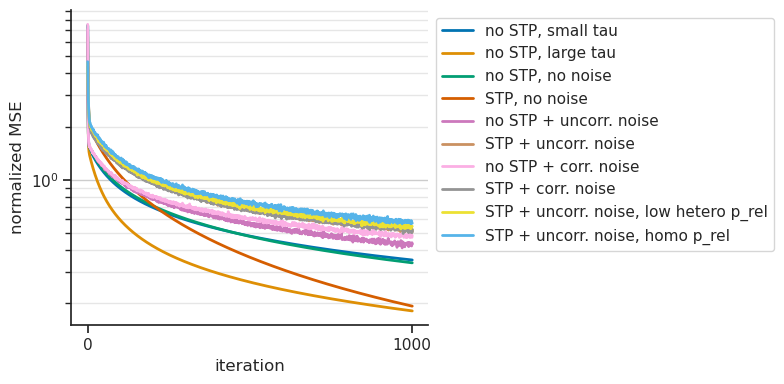

In [34]:
# plot avg learning curve across conditions on one set of axes
cm_hidden = sns.color_palette('colorblind')
fig_learning, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.set_prop_cycle(cycler('color', cm_hidden))

losses_avg = np.mean(loss_curve, axis=0)
trial_idxs = np.arange(loss_curve.shape[2])
for c_idx, sim_type in enumerate(sim_type_labels):
    losses_sim_type = losses_avg[c_idx, :]
    axes.semilogy(trial_idxs, losses_sim_type, lw=2, label=sim_type)
axes.grid(axis='y')
axes.grid(which="minor", color="0.9")
ub_xtick = trial_idxs[-1]
axes.set_xticks([0, ub_xtick])
axes.set_xlabel('iteration')
axes.set_ylabel('normalized MSE')
axes.legend(ncols=1, loc='upper left', bbox_to_anchor=(1, 1))
fig_learning.tight_layout()
fname = 'learning.png'
fig_learning.savefig(op.join('/home/ryan/Desktop', fname))